<a href="https://colab.research.google.com/github/djadczak956/MA4635/blob/main/Jadczak_Damian_HW3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 13 from ISLP
This uses the ```Weekly``` dataset from ISLP, which is I why I import it. Unfortunately, ISLP breaks everything so I have to reinstall my other packages.

In [1]:
! pip install ISLP
! pip install --upgrade --force-reinstall numpy scipy pandas seaborn statsmodels

  Using cached scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2

## Importing Packages

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP import confusion_table
from ISLP.models import contrast
from ISLP.models import ModelSpec as MS
from ISLP.models import summarize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Loading Dataset
The ```Weekly``` dataset can be found [here](https://intro-stat-learning.github.io/ISLP/datasets/Weekly.html).

In [2]:
Weekly = load_data('Weekly')
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [3]:
data = Weekly.dropna() # Clean data by removing missing values.

# See if there are missing values.
if data.compare(Weekly).empty:
  print("Data does not contain any null values.")
else:
  print("Missing data removed.")

Data does not contain any null values.


In [4]:
print(data.dtypes)

Year            int64
Lag1          float64
Lag2          float64
Lag3          float64
Lag4          float64
Lag5          float64
Volume        float64
Today         float64
Direction    category
dtype: object


## Numerical and Graphical Summaries (a)


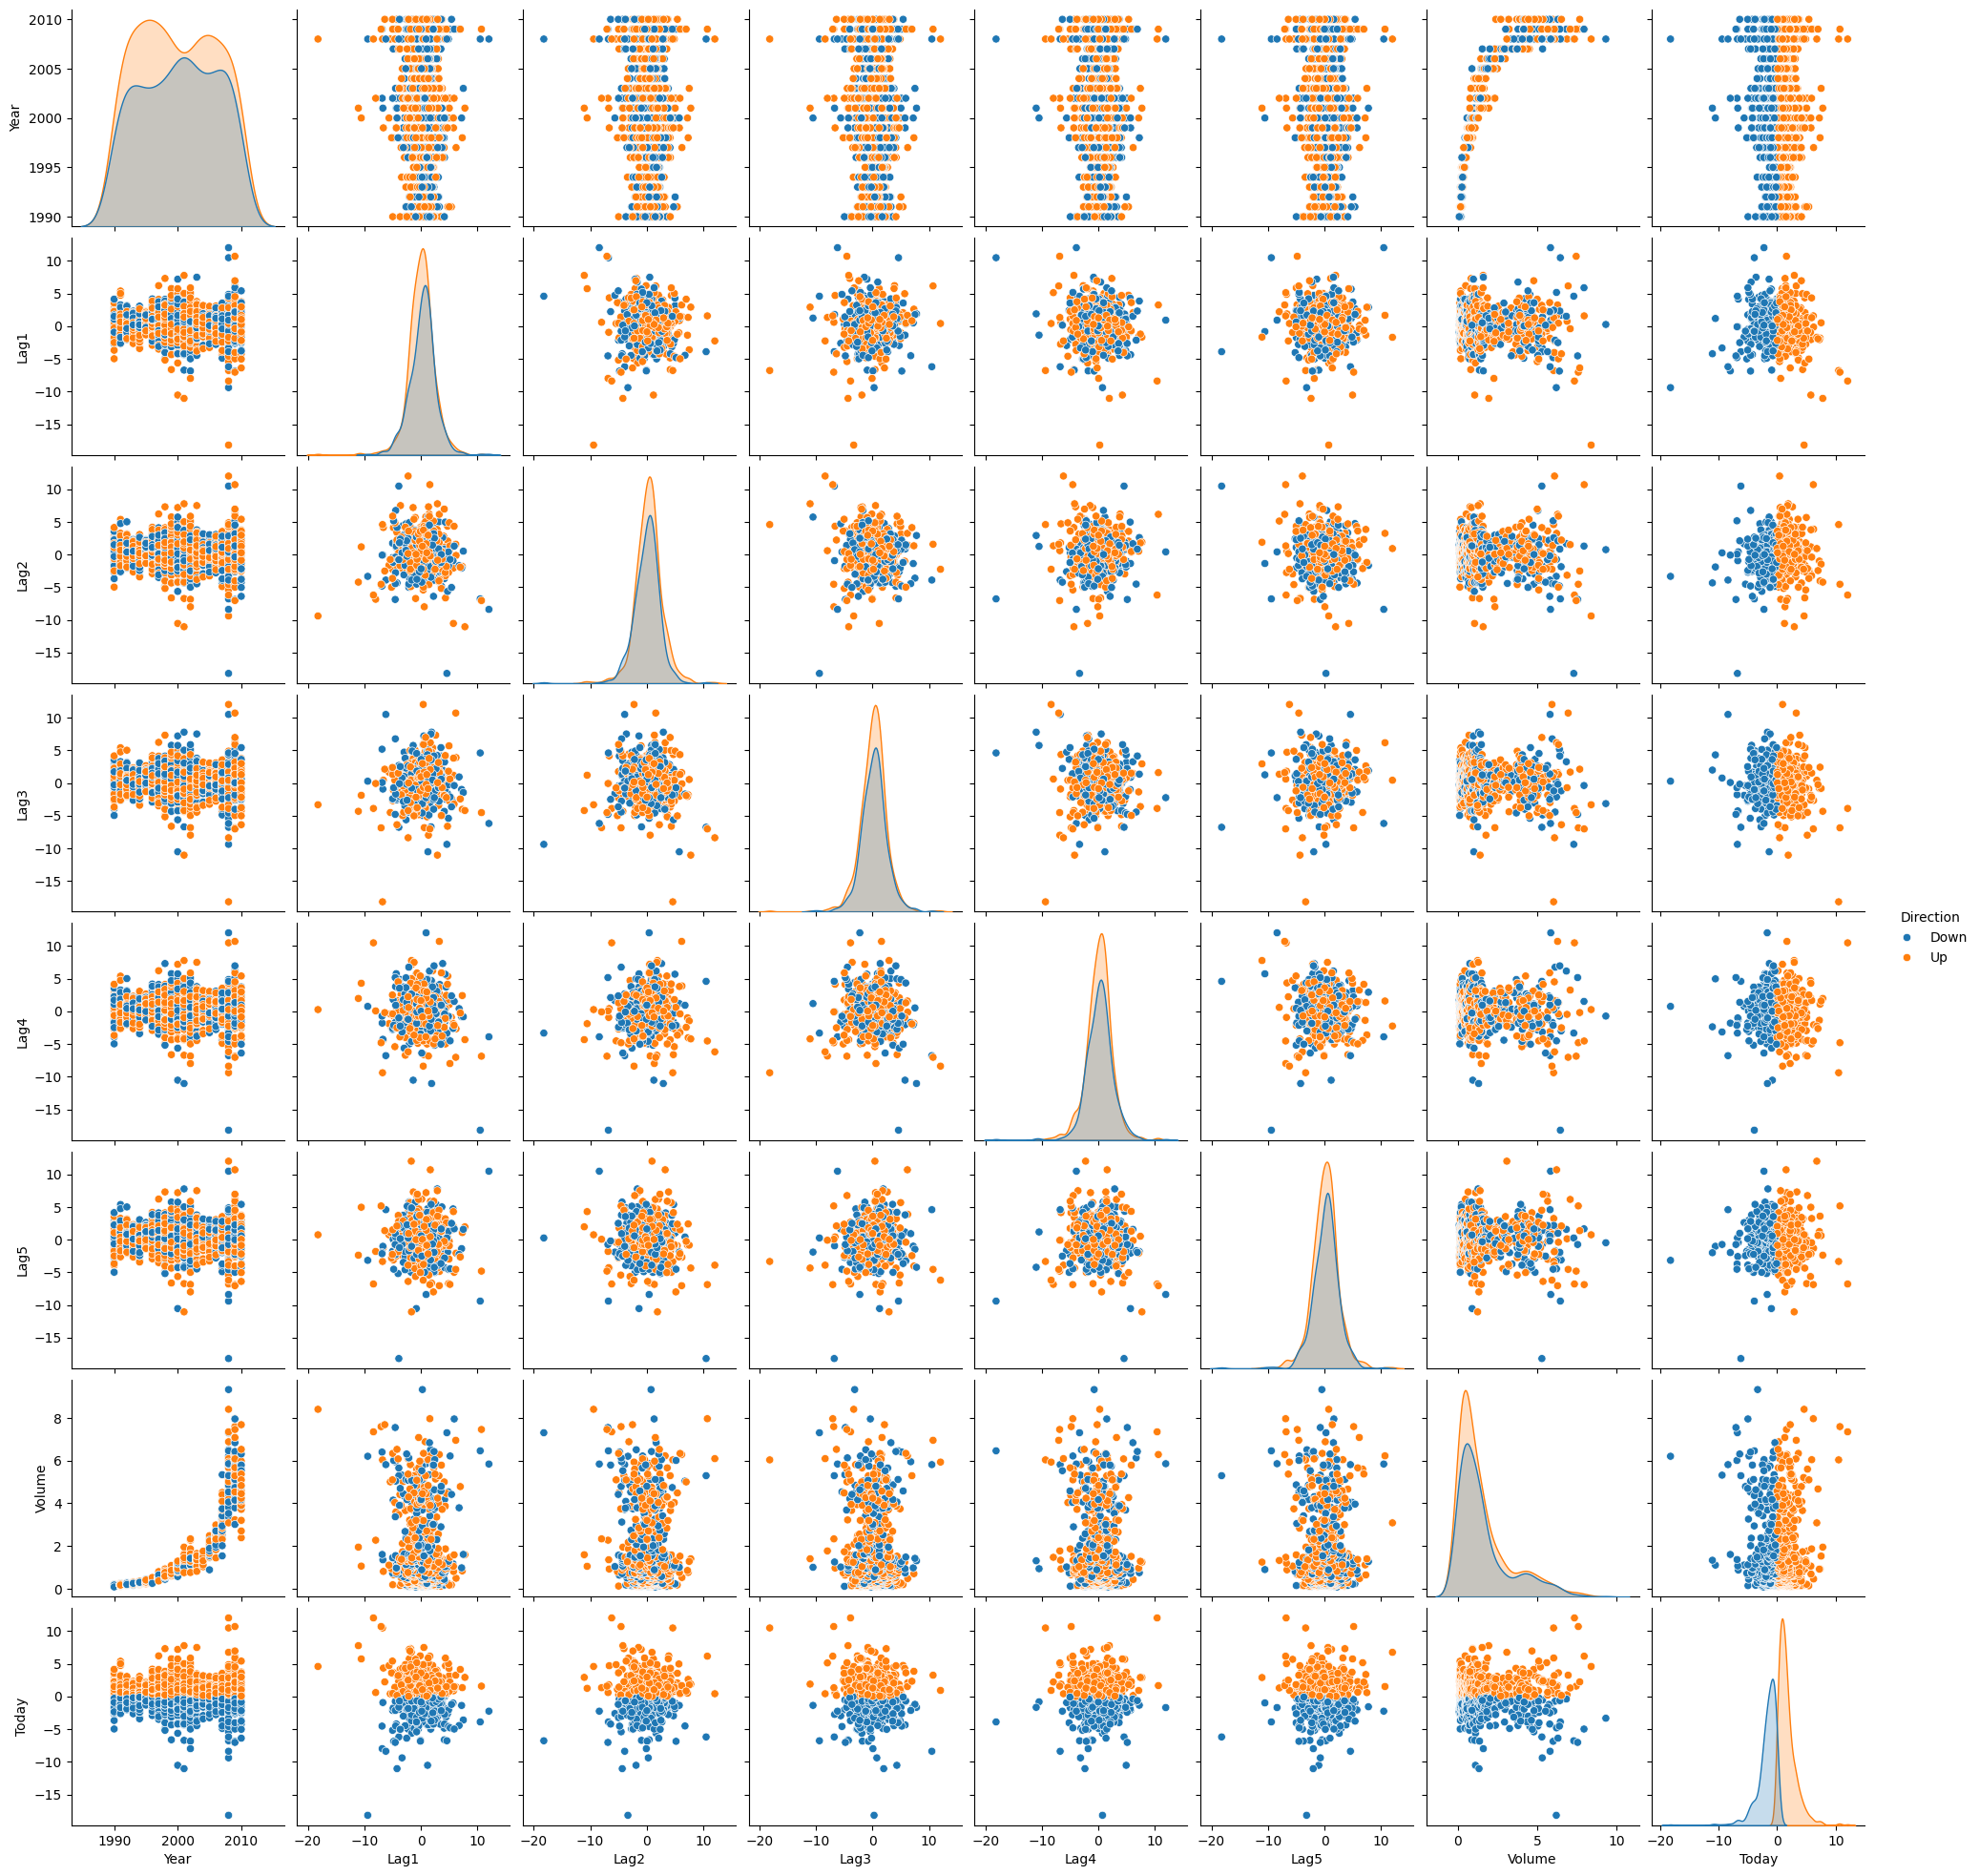

In [5]:
sns.pairplot(data, hue='Direction')

<Axes: >

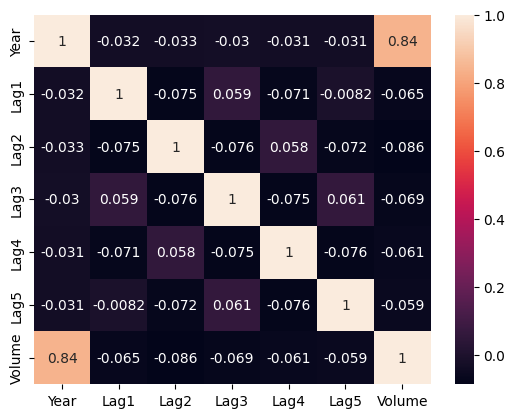

In [6]:
sns.heatmap(data.iloc[:,0:7].corr(), annot=True) # Heatmap for all columns save Direction.

There is a strong correlation between volume and year. That makes sense, as more people would participate in the stock market over time. there are weak correlations elsewhere, which can be explained by the stock market's volatility.

## Logistic Regression Model With Full Data (b)
For this logistic regression model, we will be using the 5 lag variables and volume as predictors. We will split our data into 80% training and 20% testing.

In [7]:
predictors1 = data.columns.drop(['Direction', 'Year', 'Today'])
design1 = MS(predictors1)

X1 = design1.fit_transform(data)
y1 = data['Direction'] == 'Up'

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1)

glm1 = sm.GLM(y1_train, X1_train, family=sm.families.Binomial()) # Generalized linear model, which happens to be logistic regression here.
res1 = glm1.fit()
print(res1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  871
Model:                            GLM   Df Residuals:                      864
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -596.28
Date:                Wed, 16 Apr 2025   Deviance:                       1192.6
Time:                        23:37:17   Pearson chi2:                     871.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.006639
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2011      0.096      2.089      0.0

From this, we can see ```Lag2``` was the predictor with the lowest p-value (0.113), meaning that it is the most statistically significant one. This means that with our current set of predictors, it has the lowest chance to falsly reject the null hypothesis, which states that the predictor has no relationship with the target. Unforunately, 0.113 is high for a p-value, so this should be taken with a grain of salt.

In second place is ```Lag1```, though it has a significantly higher p-value (0.310) than ```Lag2```.

### Confusion Matrix (c)

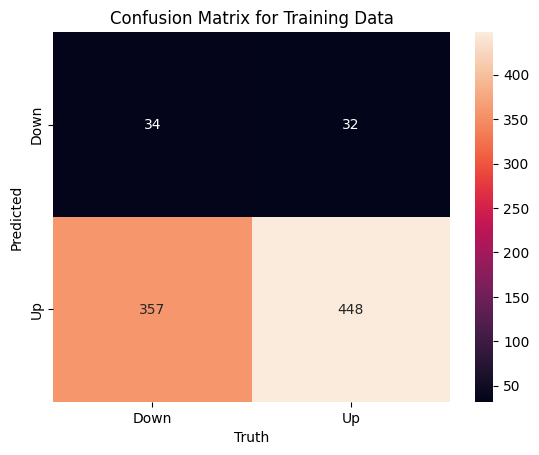

Training Accuracy: 0.5533869115958668


In [8]:
probs1_train = res1.predict(X1_train)
probs1_test = res1.predict(X1_test)

# Boolean conversions.
y1_train_bool = np.where(y1_train, 'Up', 'Down')
y1_test_bool = np.where(y1_test, 'Up', 'Down')

# Training Confusion Matrix
labels1_train = np.array(['Down'] * len(probs1_train))
labels1_train[probs1_train > 0.5] = 'Up' # Change prediction to "Up" if its probability exceeds 50%
sns.heatmap(confusion_table(labels1_train, y1_train_bool), annot=True, fmt='g')
plt.title('Confusion Matrix for Training Data')
plt.show()
print(f'Training Accuracy: {np.mean(labels1_train == y1_train_bool)}')

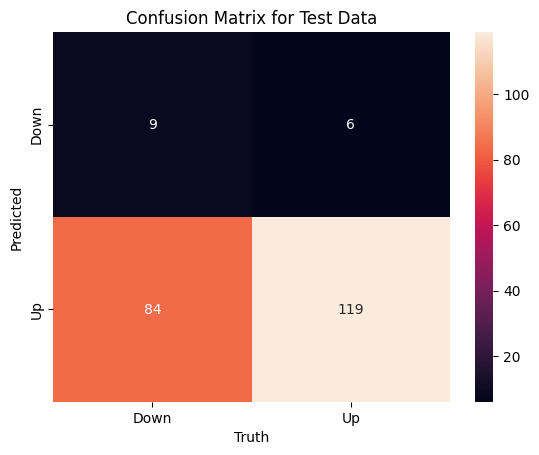

Test Accuracy: 0.5871559633027523


In [9]:
# Testing Confusion Matrix
labels1_test = np.array(['Down'] * len(probs1_test))
labels1_test[probs1_test > 0.5] = 'Up' # Change prediction to "Up" if its probability exceeds 50%
sns.heatmap(confusion_table(labels1_test, y1_test_bool), annot=True, fmt='g')
plt.title('Confusion Matrix for Test Data')
plt.show()
print(f'Test Accuracy: {np.mean(labels1_test == y1_test_bool)}')

Given the full set of data, the Logistic Regression model yields a training accuracy of 55.3% and a test accuracy of 58.7%. Interesting enough, the test accuracy is higher than the training accuracy, though I claim that to be from a stroke of luck. Overall, the model is biased towards predicting "Up", as seen in in the training and test confusion matrices.

## Logistic Regression With Limited Data (d)
This time, the model will only be fit with data from 1990 to 2008. I will exclude 2008, due to the stock market crash being possible source of outliers. We will start by defining our data and singular predictor ```Lag2```. Again, there will be an 80/20 split for training/test data.

In [10]:
data2 = data.loc[(data['Year'] >= 1990) & (data['Year'] < 2008)]
predictors2 = "Lag2" # Only 1 predictor

design2 = MS([predictors2])
X2 = design2.fit_transform(data2)
y2 = data2['Direction'] == 'Up'
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Logistic Regression Model
glm2 = sm.GLM(y2_train, X2_train, family=sm.families.Binomial())
res2 = glm2.fit()
print(res2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  746
Model:                            GLM   Df Residuals:                      744
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -513.33
Date:                Wed, 16 Apr 2025   Deviance:                       1026.7
Time:                        23:37:17   Pearson chi2:                     746.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.004810
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1313      0.074      1.776      0.0

Let us make a method for producing confusion matrices for testing and training data.

In [11]:
# Generates confusions matrices for testing and training data of model.
def generate_confusion_matrix(model_res, X_train, X_test, y_train, y_test):
  prob_train = model_res.predict(X_train)
  prob_test = model_res.predict(X_test)
  y_train_bool = np.where(y_train, 'Up', 'Down')
  y_test_bool = np.where(y_test, 'Up', 'Down')

  # Training Confusion Matrix
  labels_train = np.array(['Down'] * len(prob_train))
  labels_train[prob_train > 0.5] = 'Up'
  sns.heatmap(confusion_table(labels_train, y_train_bool), annot=True, fmt='g')
  plt.title('Confusion Matrix for Training Data')
  plt.show()
  print(f'Training Accuracy: {np.mean(labels_train == y_train_bool)} \n')

  # Testing Confusion Matrix
  labels_test = np.array(['Down'] * len(prob_test))
  labels_test[prob_test > 0.5] = 'Up'
  sns.heatmap(confusion_table(labels_test, y_test_bool), annot=True, fmt='g')
  plt.title('Confusion Matrix for Testing Data')
  plt.show()
  print(f'Testing Accuracy: {np.mean(labels_test == y_test_bool)} \n')

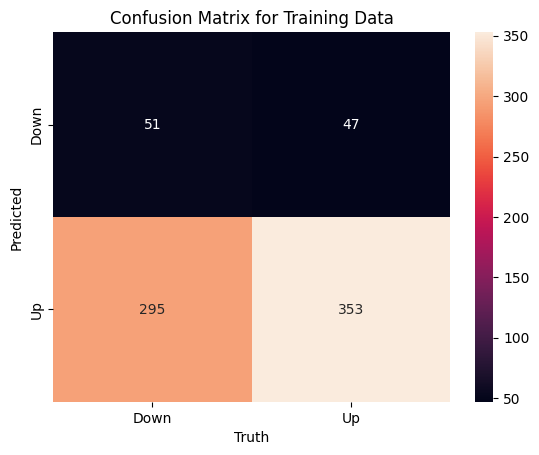

Training Accuracy: 0.5415549597855228 



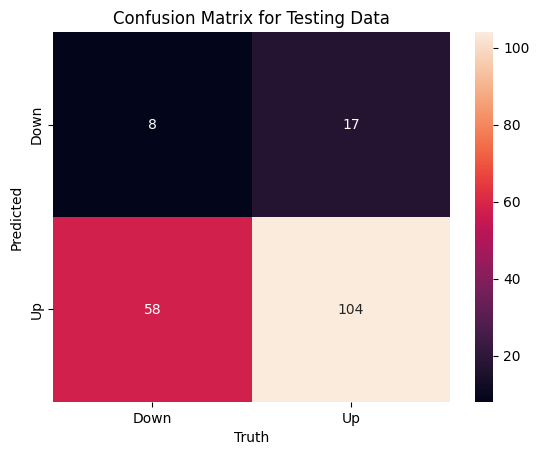

Testing Accuracy: 0.5989304812834224 



In [12]:
generate_confusion_matrix(res2, X2_train, X2_test, y2_train, y2_test)

The testing and training accuracies are nothing to be impressed by here. I tried with both the inclusion and exclusion of 2008 in this range of data, and there was not a significant difference between them. Again, the testing accuracy is higher than the training accuracy, which is perhaps from a stroke of luck. This model performs worse than the Logistic Regression with the full dataset.

## LDA With Limited Data (e)

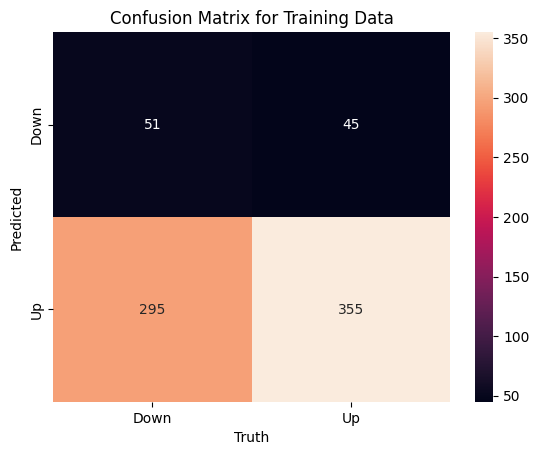

Training Accuracy: 0.5442359249329759 



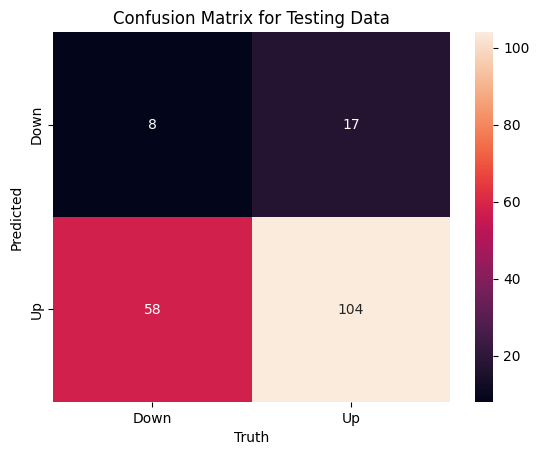

Testing Accuracy: 0.5989304812834224 



In [13]:
lda = LDA(store_covariance=True)

# Drop intercepts since sklearn LDA function automatically adds them in.
X2_train_sklearn, X2_test_sklearn = [M.drop(columns=['intercept']) for M in [X2_train, X2_test]]
lda.fit(X2_train_sklearn, y2_train)

generate_confusion_matrix(lda, X2_train_sklearn, X2_test_sklearn, y2_train, y2_test)

Strangely enough, this yields the exact same results as the Logistic Regression from part (d) when using ```random_state=1```. The book describes getting very similar results for LDA and Logistic Regression for Lab 4.7, so I will not rule it out as a possibility. This is still biased towards predicting positive returns.

When swapped to ```random_state=42```, I see that results confusion matrices for training data are slightly different, though the test confusion matrices remained the same.

## QDA With Limited Data (f)

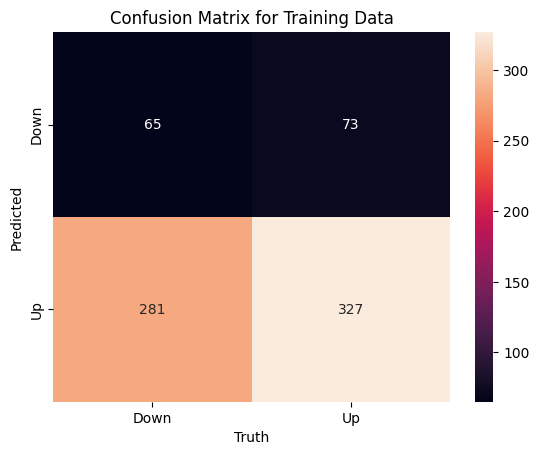

Training Accuracy: 0.5254691689008043 



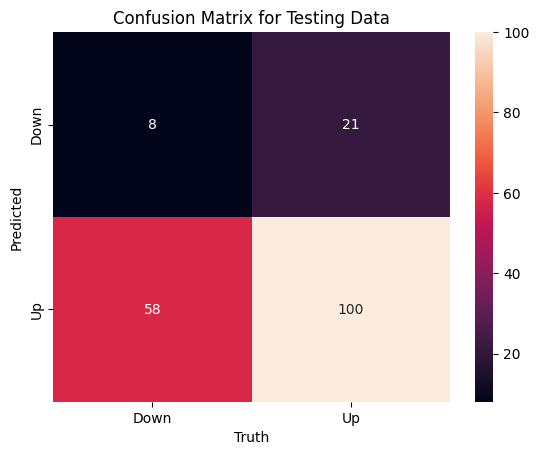

Testing Accuracy: 0.5775401069518716 



In [14]:
qda = QDA(store_covariance=True)
qda.fit(X2_train_sklearn, y2_train)

generate_confusion_matrix(qda, X2_train_sklearn, X2_test_sklearn, y2_train, y2_test)

This has a higher test accuracy than LDA, however, there is the issue of this model being very biased towards predicting positive returns. This model does not predict negative returns at all based on the current data split.

## KNN via K=1 With Limited Data (g)

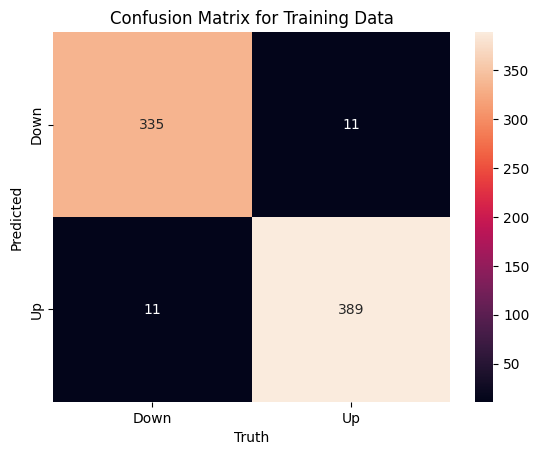

Training Accuracy: 0.9705093833780161 



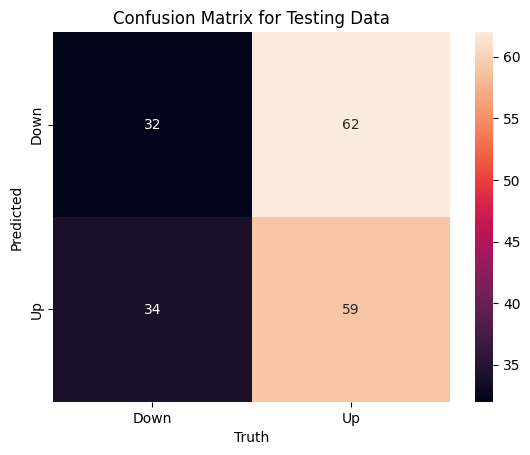

Testing Accuracy: 0.48663101604278075 



In [15]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X2_train_sklearn, y2_train)

generate_confusion_matrix(knn1, X2_train_sklearn, X2_test_sklearn, y2_train, y2_test)

This model has remarkable training accuracy, but it has the lowest test accuracy so far, compared to all of the models. I claim that the testing accuracy is better than the training accuracy due to the sheer amount of data, because KNN is a nonparametric method, meaning it needs a large amount of data to be an effective method.

## Naive Bayes With Limited Data (h)

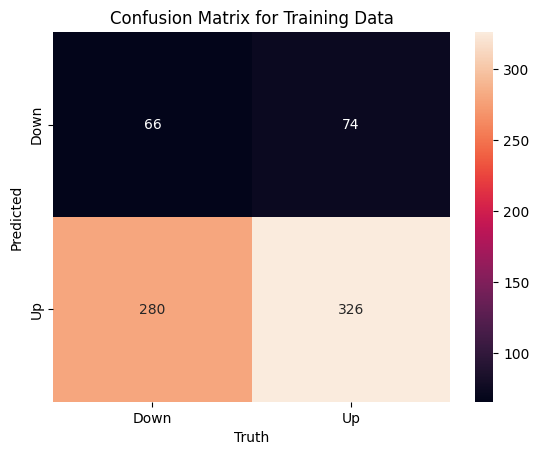

Training Accuracy: 0.5254691689008043 



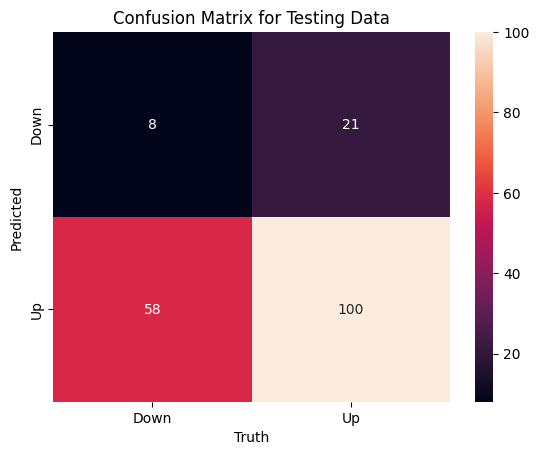

Testing Accuracy: 0.5775401069518716 



In [16]:
NB = GaussianNB()
NB.fit(X2_train_sklearn, y2_train)

generate_confusion_matrix(NB, X2_train_sklearn, X2_test_sklearn, y2_train, y2_test)

This happens to be very similar to the results of QDA (in fact, they were the same when I used ```random_state=1``` and test results are the same with ```random_state=42```).

## Logistic Regression and LDA Provide The Best Results (i)
Regarding test accuracy, they are both tied at 59.89% for testing accuracy.

## Experiment (j)
I am interested in experimenting with KNN, since we can modify K and the predictors. I will start with a function to calculate accuracy for testing and training data.

In [23]:
def calculate_error(model_res, X_train, X_test, y_train, y_test):
  prob_train = model_res.predict(X_train)
  prob_test = model_res.predict(X_test)
  y_train_bool = np.where(y_train, 'Up', 'Down')
  y_test_bool = np.where(y_test, 'Up', 'Down')

  # Training Accuracy
  labels_train = np.array(['Down'] * len(prob_train))
  labels_train[prob_train > 0.5] = 'Up'
  print(f'\tTraining Accuracy: {np.mean(labels_train == y_train_bool)} \n')

  # Testing Accuracy
  labels_test = np.array(['Down'] * len(prob_test))
  labels_test[prob_test > 0.5] = 'Up'
  print(f'\tTesting Accuracy: {np.mean(labels_test == y_test_bool)} \n')

In [25]:
for i in range(1,11):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X2_train_sklearn, y2_train)
  print(f'K = {i}')
  calculate_error(knn, X2_train_sklearn, X2_test_sklearn, y2_train, y2_test)

K = 1
	Training Accuracy: 0.9705093833780161 

	Testing Accuracy: 0.48663101604278075 

K = 2
	Training Accuracy: 0.7359249329758714 

	Testing Accuracy: 0.44385026737967914 

K = 3
	Training Accuracy: 0.7453083109919572 

	Testing Accuracy: 0.5080213903743316 

K = 4
	Training Accuracy: 0.6863270777479893 

	Testing Accuracy: 0.48128342245989303 

K = 5
	Training Accuracy: 0.6729222520107239 

	Testing Accuracy: 0.5240641711229946 

K = 6
	Training Accuracy: 0.6702412868632708 

	Testing Accuracy: 0.4919786096256685 

K = 7
	Training Accuracy: 0.6689008042895442 

	Testing Accuracy: 0.5080213903743316 

K = 8
	Training Accuracy: 0.6528150134048257 

	Testing Accuracy: 0.44385026737967914 

K = 9
	Training Accuracy: 0.6528150134048257 

	Testing Accuracy: 0.4919786096256685 

K = 10
	Training Accuracy: 0.6434316353887399 

	Testing Accuracy: 0.4919786096256685 



With the limited data and ```Lag2``` predictor, we see the best testing accuracy at K = 5, which happens to be 52.41%. Suppose we implement the ```Lag1``` predictor as well.

In [30]:
predictors3 = ['Lag1', 'Lag2']

design3 = MS(predictors3)
X3 = design3.fit_transform(data2)
y3 = data2['Direction'] == 'Up'
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [31]:
for i in range(1,11):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X3_train, y3_train)
  print(f'K = {i}')
  calculate_error(knn, X3_train, X3_test, y3_train, y3_test)

K = 1
	Training Accuracy: 1.0 

	Testing Accuracy: 0.48663101604278075 

K = 2
	Training Accuracy: 0.7828418230563002 

	Testing Accuracy: 0.43315508021390375 

K = 3
	Training Accuracy: 0.7707774798927614 

	Testing Accuracy: 0.5614973262032086 

K = 4
	Training Accuracy: 0.7144772117962467 

	Testing Accuracy: 0.5080213903743316 

K = 5
	Training Accuracy: 0.7238605898123325 

	Testing Accuracy: 0.5347593582887701 

K = 6
	Training Accuracy: 0.6876675603217158 

	Testing Accuracy: 0.5294117647058824 

K = 7
	Training Accuracy: 0.6863270777479893 

	Testing Accuracy: 0.5614973262032086 

K = 8
	Training Accuracy: 0.6447721179624665 

	Testing Accuracy: 0.5133689839572193 

K = 9
	Training Accuracy: 0.6541554959785523 

	Testing Accuracy: 0.5561497326203209 

K = 10
	Training Accuracy: 0.631367292225201 

	Testing Accuracy: 0.4919786096256685 



We seem to get better accuracy overall. We will try the other methods with the addition of ```Lag1```.

In [33]:
print('LDA:')
lda2 = LDA(store_covariance=True)
lda2.fit(X3_train, y3_train)
calculate_error(lda2, X3_train, X3_test, y3_train, y3_test)

print('QDA')
qda2 = QDA(store_covariance=True)
qda2.fit(X3_train, y3_train)
calculate_error(qda2, X3_train, X3_test, y3_train, y3_test)

LDA:
	Training Accuracy: 0.5482573726541555 

	Testing Accuracy: 0.6203208556149733 

QDA
	Training Accuracy: 0.46380697050938335 

	Testing Accuracy: 0.35294117647058826 



/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1052: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1052: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1055: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s

From LDA, we get a testing accuracy of 62.03%, which is the highest we have achieved so far. Let us try Naive Bayes.

In [35]:
NB2 = GaussianNB()
NB2.fit(X3_train, y3_train)
calculate_error(NB2, X3_train, X3_test, y3_train, y3_test)

	Training Accuracy: 0.5415549597855228 

	Testing Accuracy: 0.5828877005347594 

